<a href="https://colab.research.google.com/github/fdeloscogna/Python_experiment/blob/main/Tesi_Python_NORMAL_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight
from torch.utils.data import DataLoader,Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.models import Model
from torchvision import models,transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import time

import matplotlib.pyplot as plt

import seaborn as sns

import random
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seeds
set_seeds()

Mounted at /content/drive


In [2]:
# Setting the device
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

GPU enabled!


In [3]:
#Import the dataset available
image_directory = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification'
labels_file_path = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification/labels.csv'
#read the labeled data
labeled_data = pd.read_csv(labels_file_path)
# Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.
# Get the labeled image filenames and their corresponding labels
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1

In [4]:
#Let's impose a custom dataset CustomDataset class is designed to be flexible,
#To provide filenames and labels explicitly or read them from a CSV file because It supports image transformations for data augmentation
class CustomDataset(Dataset):
    def __init__(self, image_directory, labels_file_path, transform=None, provided_filenames=None, provided_labels=None):
        """
        CustomDataset builder section.
        Parameters considered in the function:
        - transform (callable, optional): here it is a optional transform to be applied to the images.
        - provided_filenames (list, optional): List of filenames corresponding to the images.
        - provided_labels (list, optional): List of labels corresponding to the images.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labels_file_path)
        self.transform = transform

        # Use provided filenames and labels if available
        if provided_filenames is not None and provided_labels is not None:
            self.filenames = provided_filenames
            self.labels = provided_labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        The folowing part it gives the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.
        Parameters:
        - idx (int): Index of the item to retrieve.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        #Since, from literature, many machine learning models and image processing libraries expect images to be in RGB format for consistency.
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        #It return here a tuble with the image and its label
        return image, label

In [5]:
max_width = 0
max_height = 0
# Initialize variables to store the maximum width and height of the images.

for file_name in labeled_filenames:
    file_path = os.path.join(image_directory, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)
    '''
    Iterate over the labeled_filenames and open each image using PIL.
    Get the width and height of each image and update the maximum width and height if necessary.
    '''

In [6]:
transform_basic = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



dataset_basic = CustomDataset(image_directory, labels_file_path, transform = transform_basic)
stacked_dataset = ConcatDataset([dataset_basic])
stacked_labels = np.concatenate([labels])

k_folds = 8
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the current fold
    train_data = [dataset_basic[idx] for idx in train_index]
    val_data = [dataset_basic[idx] for idx in val_index]


    # Calculate class weights
    weights_of_classes = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    '''
    Compute the class weights by taking the reciprocal of the counts of each class in the training set.
    This gives more weight to underrepresented classes and less weight to overrepresented classes.
    '''
    train_class_weights = weights_of_classes[stacked_labels[train_index]]
    # Extract the class weights corresponding to the training labels.

    # Create the weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)
    '''
    Create a WeightedRandomSampler, which samples elements from the training data with replacement
    according to the specified class weights. This oversamples the underrepresented classes
    during training to balance the class distribution.
    '''
    # Create the data loaders with weighted sampling
    batch_size = 8
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    # Create a DataLoader for the training data, using the WeightedRandomSampler to sample batches.
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Create a DataLoader for the validation data without sampling, shuffling the data within each

Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - ResNet50 Training Loss: 1.0755
Epoch 2/15 - ResNet50 Training Loss: 1.1500
Epoch 3/15 - ResNet50 Training Loss: 1.1801
Epoch 4/15 - ResNet50 Training Loss: 1.1653
Epoch 5/15 - ResNet50 Training Loss: 0.9675
Epoch 6/15 - ResNet50 Training Loss: 1.0306
Epoch 7/15 - ResNet50 Training Loss: 0.9544
Epoch 8/15 - ResNet50 Training Loss: 1.0666
Epoch 9/15 - ResNet50 Training Loss: 0.9741
Epoch 10/15 - ResNet50 Training Loss: 1.1974
Epoch 11/15 - ResNet50 Training Loss: 1.0138
Epoch 12/15 - ResNet50 Training Loss: 0.8634
Epoch 13/15 - ResNet50 Training Loss: 0.9412
Epoch 14/15 - ResNet50 Training Loss: 0.7763
Epoch 15/15 - ResNet50 Training Loss: 0.7794
Total Time: 176.19 seconds


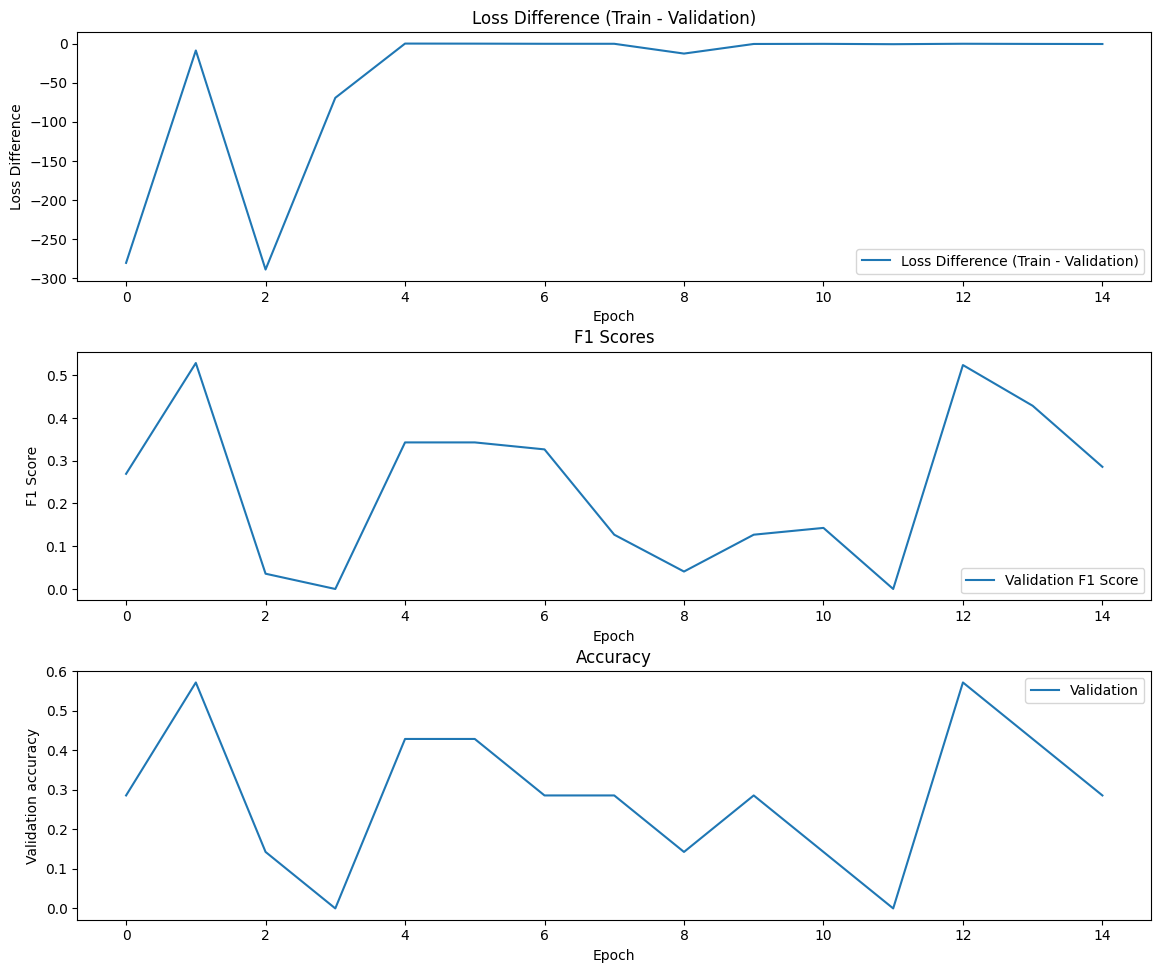

In [19]:
##################################################
# Resnet 50
##################################################
num_classes = 3  # +1 0 -1
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)  # Modify the output layer

# Move the model to the device (GPU if available)
resnet_model = resnet_model.to(device)

# Define the loss function and optimizer
parameter_loss = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

# Initialize lists to store training and validation metrics
train_losses = []
val_accuracies_pre = []
val_f1_scores_pre = []
val_accuracies = []
val_losses = []
#track_time_pre_append = []

track_time_pre = time.time()

num_epochs = 15
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = parameter_loss(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")


    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = parameter_loss(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to the respective lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    val_loss /= len(val_dataloader)

    val_f1_pre = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_pre = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_pre.append(val_f1_pre)      # Replace with actual validation F1 score
    val_accuracies_pre.append(val_accuracy_pre)      # Replace with actual validation accuracy

finish_end_time_pre = time.time()

# Calculate the total training time
total_time_pre = finish_end_time_pre - track_time_pre

loss_difference_pre = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=[12, 10])  # Two rows and two columns of subplots
fig.tight_layout(pad=3.0)
# Plot the loss difference
axs[0].plot(loss_difference_pre, label='Loss Difference (Train - Validation)')
axs[0].set_title('Loss Difference (Train - Validation)')
axs[0].set_ylabel('Loss Difference')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training and validation F1 scores
axs[1].plot(val_f1_scores_pre, label='Validation F1 Score')
axs[1].set_title('F1 Scores')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend()

#Accuracy
axs[2].plot(val_accuracies_pre, label='Validation')
axs[2].set_title('Accuracy')
axs[2].set_ylabel('Validation accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend()

print(f"Total Time: {total_time_pre:.2f} seconds")


plt.show()

VGG 16 without augmented dataset

In [12]:
##################################################
# VGG 16
##################################################

weight = models.VGG16_Weights.DEFAULT
pre_model = models.vgg16(weights = weight)

# Freeze all the parameters of the pretrained models
for param in pre_model.parameters():
    param.requires_grad = False

num_classes = 3
last_item_index = len(pre_model.classifier) - 1
old_fc = pre_model.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features,
                   out_features= num_classes, bias=True)
pre_model.classifier.__setitem__(last_item_index , new_fc)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 53.7MB/s]


In [13]:
pre_model = pre_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(pre_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [20]:
val_f1_scores_vgg = []
train_accuracies = []
val_accuracies_vgg = []
train_losses = []
val_losses = []  # Initialize an empty list to store validation accuracies

Epoch 1/15 - VGG 16 Training Loss: 0.2190
Epoch 2/15 - VGG 16 Training Loss: 0.2656
Epoch 3/15 - VGG 16 Training Loss: 0.3689
Epoch 4/15 - VGG 16 Training Loss: 0.2499
Epoch 5/15 - VGG 16 Training Loss: 0.2859
Epoch 6/15 - VGG 16 Training Loss: 0.3311
Epoch 7/15 - VGG 16 Training Loss: 0.2650
Epoch 8/15 - VGG 16 Training Loss: 0.2554
Epoch 9/15 - VGG 16 Training Loss: 0.2544
Epoch 10/15 - VGG 16 Training Loss: 0.2703
Epoch 11/15 - VGG 16 Training Loss: 0.2288
Epoch 12/15 - VGG 16 Training Loss: 0.2290
Epoch 13/15 - VGG 16 Training Loss: 0.2298
Epoch 14/15 - VGG 16 Training Loss: 0.2318
Epoch 15/15 - VGG 16 Training Loss: 0.2167
Epoch 15/15 - Validation Loss: 0.8898, F1 Score: 0.5238, Accuracy: 0.5714
Total Time: 97.69 seconds


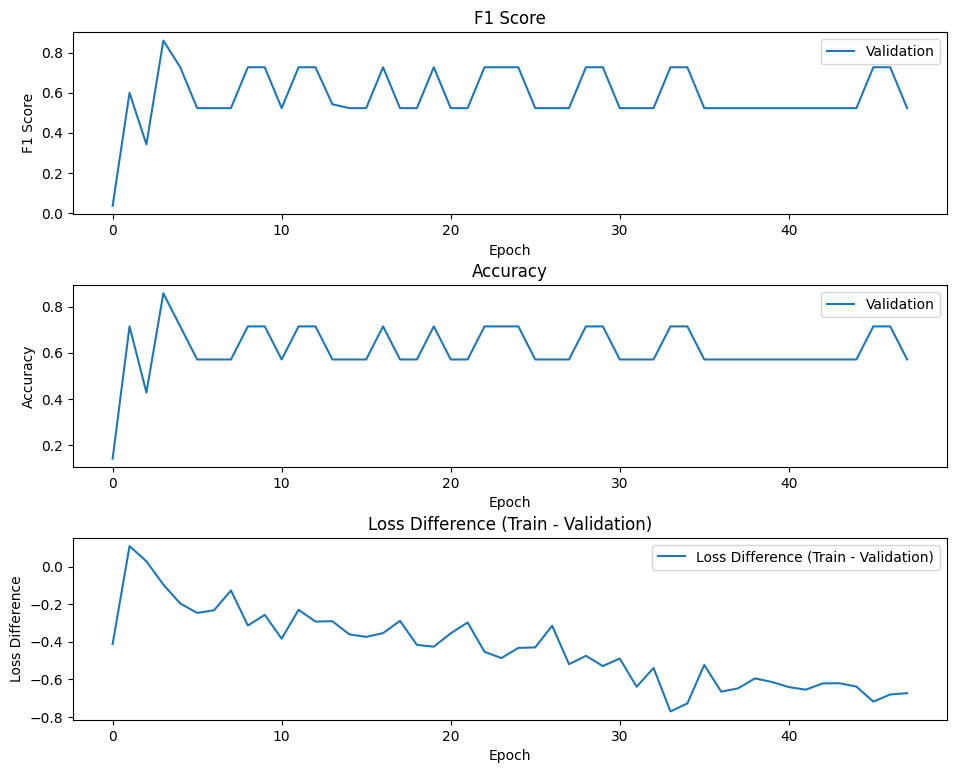

In [25]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

track_time_vgg = time.time()

num_epochs = 15
# Set the number of training epochs.
for epoch in range(num_epochs):
    # Training phase for ResNet50
    pre_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
        # Initialize the confusion matrix.
        # Move the images and labels to the specified device (GPU if available).

        optimizer_vgg.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = pre_model(images)
        # Perform a forward pass of the images through the ResNet50 model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_vgg.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - VGG 16 Training Loss: {epoch_loss:.4f}")

    # Print the training loss for the current epoch.
    # Validation phase
    pre_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            premodel_outputs = pre_model(images)
            premodel_loss = parameter_loss(premodel_outputs, labels)

            val_loss += premodel_loss.item()

            _, predictions = torch.max(premodel_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)


            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))
    #print("Confusion Matrix:")
    #print(confusion)

    val_loss /= len(val_dataloader)

    val_f1_vgg = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_vgg = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_vgg.append(val_f1_vgg)
    val_accuracies_vgg.append(val_accuracy_vgg)
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_vgg:.4f}, Accuracy: {val_accuracy_vgg:.4f}")
loss_difference_vgg = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

finish_end_time_vgg = time.time()

# Calculate the total training time
total_time_vgg = finish_end_time_vgg - track_time_vgg

print(f"Total Time: {total_time_vgg:.2f} seconds")


# Plot the loss difference
axs[2].plot(loss_difference_vgg, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_vgg, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_vgg, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

Google Net

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 200MB/s]


Epoch 1/15 - GoogLeNet Training Loss: 0.9894
Epoch 1/15 - Validation Loss: 2.5945, F1 Score: 0.0357, Accuracy: 0.1429
Epoch 2/15 - GoogLeNet Training Loss: 0.8498
Epoch 2/15 - Validation Loss: 2.1774, F1 Score: 0.6000, Accuracy: 0.7143
Epoch 3/15 - GoogLeNet Training Loss: 0.5536
Epoch 3/15 - Validation Loss: 2.9369, F1 Score: 0.5000, Accuracy: 0.5714
Epoch 4/15 - GoogLeNet Training Loss: 0.5905
Epoch 4/15 - Validation Loss: 9.8203, F1 Score: 0.0357, Accuracy: 0.1429
Epoch 5/15 - GoogLeNet Training Loss: 0.6275
Epoch 5/15 - Validation Loss: 8.3184, F1 Score: 0.0357, Accuracy: 0.1429
Epoch 6/15 - GoogLeNet Training Loss: 0.3120
Epoch 6/15 - Validation Loss: 1.5574, F1 Score: 0.6095, Accuracy: 0.5714
Epoch 7/15 - GoogLeNet Training Loss: 0.2208
Epoch 7/15 - Validation Loss: 0.4710, F1 Score: 0.8413, Accuracy: 0.8571
Epoch 8/15 - GoogLeNet Training Loss: 0.4816
Epoch 8/15 - Validation Loss: 2.3163, F1 Score: 0.2694, Accuracy: 0.2857
Epoch 9/15 - GoogLeNet Training Loss: 0.3661
Epoch 9/15 

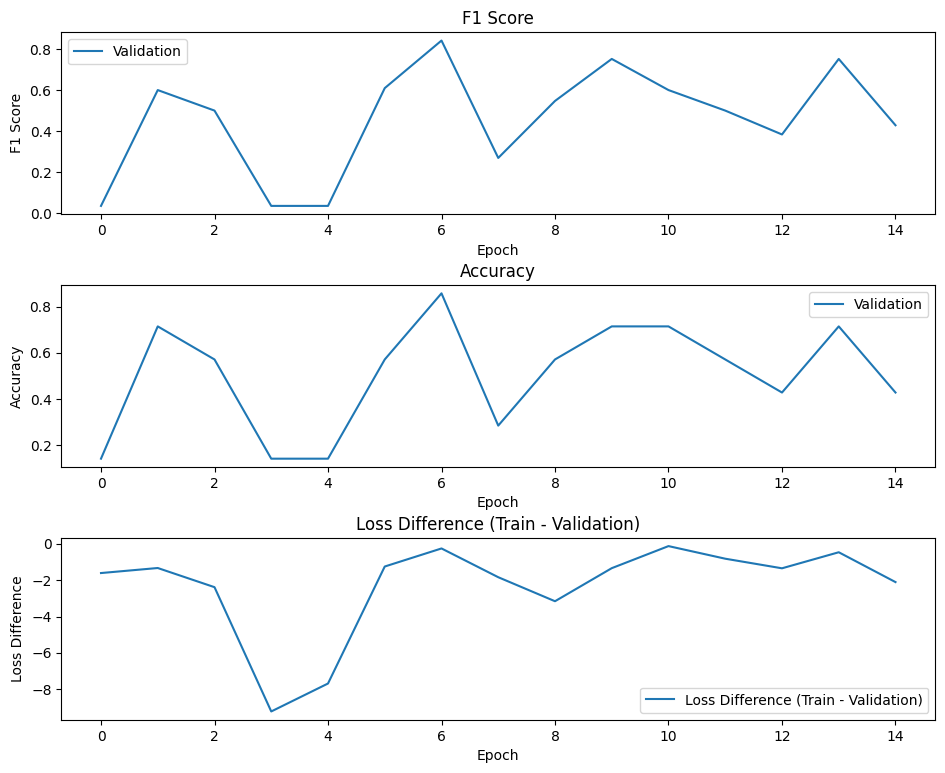

In [38]:
##################################################
# Google Net
##################################################

fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

# Lists to store training and validation F1 scores and accuracies
val_f1_scores_google = []
train_accuracies = []
val_accuracies_score_google = []
train_losses = []
val_losses = []

pesigoogle = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=pesigoogle)
num_classes = 3
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

track_time_google = time.time()
num_epochs = 15
for epoch in range(num_epochs):
    # Training phase for GoogLeNet
    googlenet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation for the gradients of the loss w.r.t the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.

    googlenet_model.eval()

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = parameter_loss(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (googlenet_loss)
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((googlenet_outputs), dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1_google = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy_google = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_google.append(val_f1_google)      # Replace with actual validation F1 score
    val_accuracies_score_google.append(val_accuracy_google)      # Replace with actual validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_google:.4f}, Accuracy: {val_accuracy_google:.4f}")
finish_end_time_google = time.time()

# Calculate the total training time
total_time_google = finish_end_time_google - track_time_google

print(f"Total Time: {total_time_google:.2f} seconds")

loss_difference_google = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
axs[2].plot(loss_difference_google, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_google, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_score_google, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

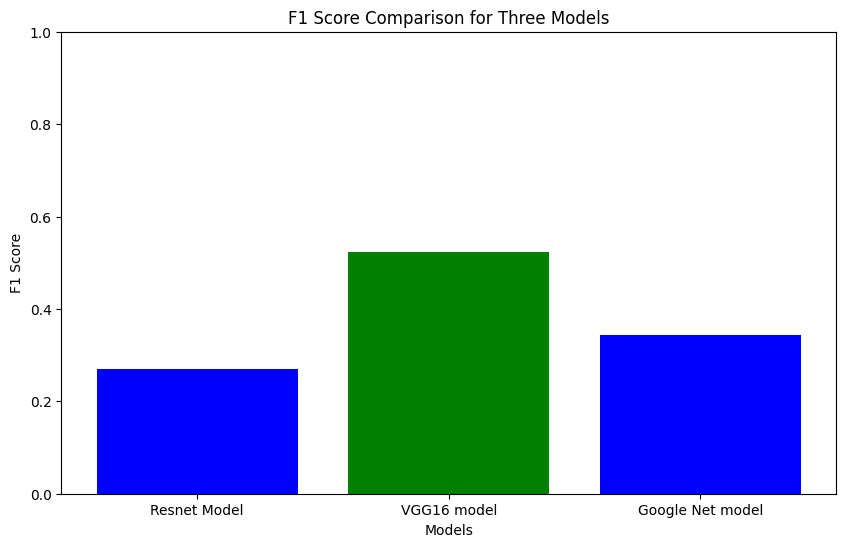

In [ ]:
model_names = ['Resnet Model', 'VGG16 model', 'Google Net model']
f1_scores = []

f1_scores.append(val_f1_pre)
f1_scores.append(val_f1_vgg)
f1_scores.append(val_f1_google)

best_model_idx = f1_scores.index(max(f1_scores))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Three Models for the non augmented dataset')
plt.ylim(0, 1)
plt.show()

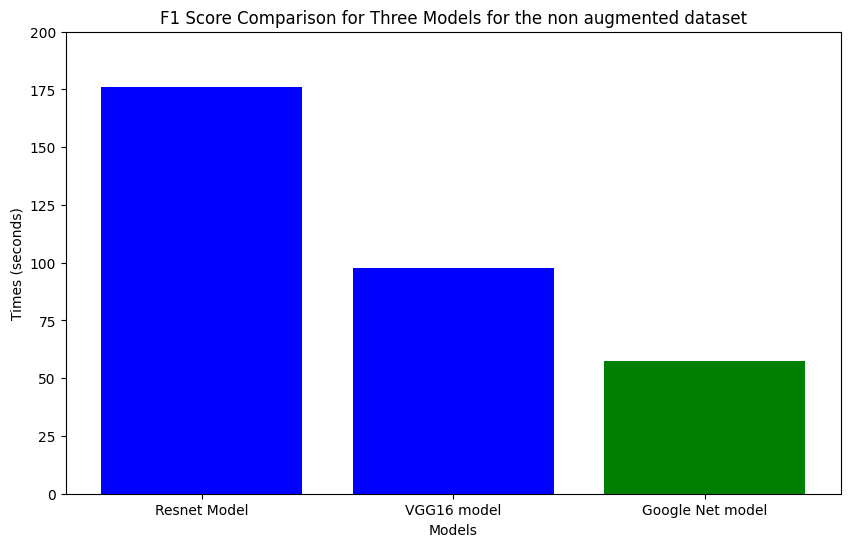

In [39]:
model_names = ['Resnet Model', 'VGG16 model', 'Google Net model']
running_times = []

running_times.append(total_time_pre)
running_times.append(total_time_vgg)
running_times.append(total_time_google)

best_model_idx = running_times.index(min(running_times))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, running_times, color=colors)
plt.xlabel('Models')
plt.ylabel('Times (seconds)')
plt.title('F1 Score Comparison for Three Models for the non augmented dataset')
plt.ylim(0, 200)
plt.show()

In [36]:
total_time_vgg

97.68793106079102